In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


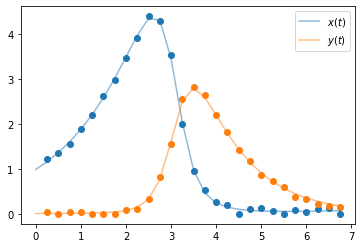

In [15]:
# Модель Лотки-Вольтерра
def LV(y, t, p):
    dx = (p[0] - p[1] * y[1]) * y[0]
    dy = (-p[2] + p[3] * y[0]) * y[1]
    return [dx, dy]

times = np.arange(0, 7, 0.25)

#beta, gamma = 4, 1.0
alpha, beta, gamma, delta = 0.66, 1.33, 1.0, 1.0

# Create true curves

#y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
y = odeint(LV, t=times, y0=[0.99, 0.01], args=((alpha, beta, gamma, delta),), rtol=1e-8)

yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.05), a_min = 0, a_max = None)

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$x(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$y(t)$")
plt.legend()
plt.show()

In [16]:
lv_model = DifferentialEquation(
    func=LV,
    times=np.arange(0.25, 7, 0.25), # не включаем начальную точку
    n_states=2, # Размерность системы ОДУ 
    n_theta=4, # Размерность вектора параметров
    t0=0,
)

In [17]:
# importing pandas as pd
import pandas as pd
  
# Check the version
print(pd.__version__)

1.2.4


In [18]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    alpha = pm.Uniform("alpha", 0.1, 2.0)
    beta = pm.Uniform("beta", 0.1, 2.0)
    #gamma = pm.Uniform("gamma", 0.1, 10.0)
    #delta = pm.Uniform("delta", 0.1, 10.0)

    lv_curves = lv_model(y0=[0.99, 0.01], theta=[alpha, beta, 1.0, 1.0])

    Y = pm.Normal("Y", mu=lv_curves, sigma=sigma, observed=yobs)

    trace = pm.sample(80, tune=40, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Only 80 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nastya/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha, sigma]


Sampling 2 chains for 40 tune and 80 draw iterations (80 + 160 draws total) took 18006 seconds.
/home/nastya/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7991952232009545, but should be close to 0.9. Try to increase the number of tuning steps.


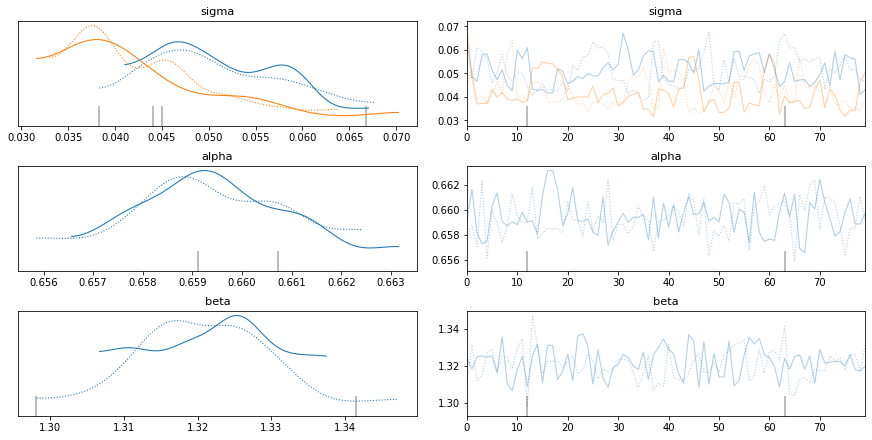

In [19]:
with model4:
    az.plot_trace(trace)

array([<AxesSubplot:title={'center':'sigma\n0'}>,
       <AxesSubplot:title={'center':'sigma\n1'}>,
       <AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

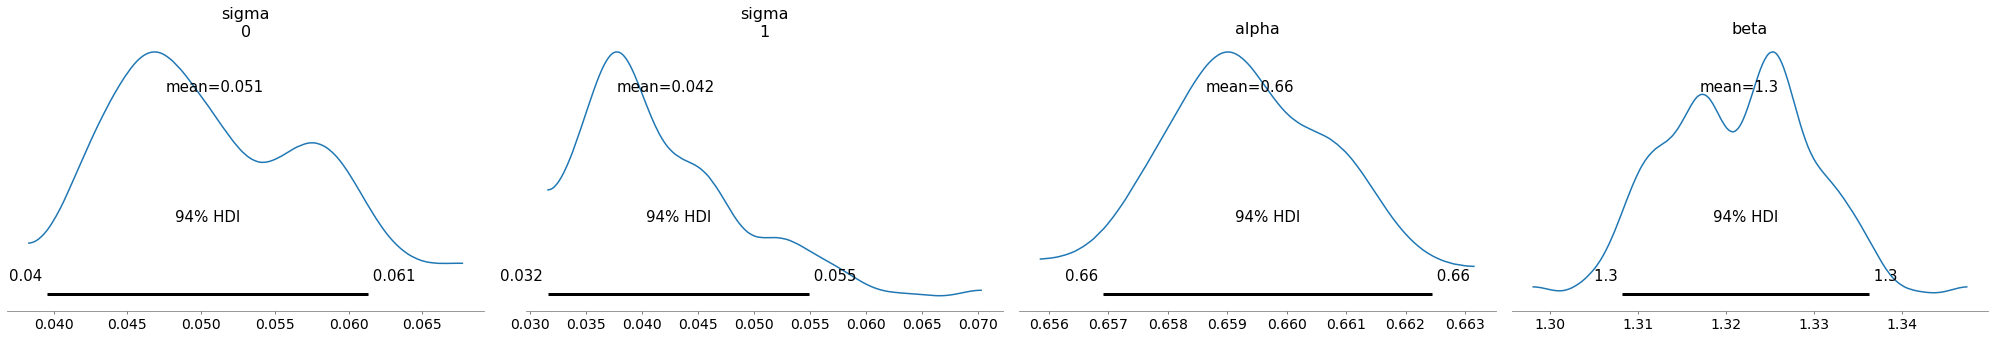

In [20]:
az.plot_posterior(data, round_to=2)